# SIM 2.0: Adaptive RPS algorithm, allocation by uncertainty reduction


In [1]:
import visualizations
from rashomon.hasse import policy_to_profile, enumerate_policies, enumerate_profiles
from rashomon.aggregate import RAggregate
from datagen import (phi_basic, phi_linear_interact, phi_grouped_smooth, phi_grouped_coarse,
                     phi_grouped_smooth2, phi_peak, generate_data_from_assignments)
from allocation import (
    compute_boundary_probabilities, get_initial_coverage_allocations,
    compute_adaptive_proxy_scores,
    get_prob_allocations,
    create_assignments_from_alloc
)
from rashomon.extract_pools import extract_pools, aggregate_pools
from rashomon.loss import compute_pool_means, compute_policy_means
from rashomon.metrics import make_predictions
from rashomon.extract_pools import lattice_edges

import numpy as np
import matplotlib.pyplot as plt

In [2]:
M = 4  # number of features
R = np.array([3, 3, 4, 2])  # levels per feature
lambda_reg = 0.001  # reg parameter
epsilon = 0.05  # tolerance off MAP
H = np.inf

max_alloc = 150
feasible_waves = 5  # first wave is smallest with just one observation per profile.

sig = 0.2

verbose = True
adaptive = False

top_k = 10
n_preview = 30

num_workers = 2
# sweep parameter until you get an RPS of a large enough size. Change step and max size depending on dimension.
theta_init = 0.01
theta_init_step = 0.005
max_rset_size = 1000  # desired minimum number of feasible combinations

In [3]:
# enumerate all policies and profiles
all_policies = enumerate_policies(M, R)
num_policies = len(all_policies)
profiles, profile_map = enumerate_profiles(M)
num_profiles = len(profiles)

# profile index mappings
policies_profiles = {}
policies_ids_profiles = {}
policies_profiles_masked = {} # the masked policies just hold the active features
for k, profile in enumerate(profiles):
    ids = [i for i, p in enumerate(all_policies) if policy_to_profile(p) == profile]
    policies_ids_profiles[k] = ids
    policies_profiles[k] = [all_policies[i] for i in ids]

    profile_mask = [bool(v) for v in profile]  # t/f map of which features are active
    masked_policies = [tuple([pol[i] for i in range(M) if profile_mask[i]]) for pol in
                       policies_profiles[k]]
    policies_profiles_masked[k] = masked_policies

lattice_edges = lattice_edges(all_policies)

neighbors = {i: [] for i in range(len(all_policies))}
for i, j in lattice_edges:
    neighbors[i].append(j)
    neighbors[j].append(i)  # edges are undirected

In [4]:
# first wave: one per profile
n = [num_profiles]
remaining_alloc = max_alloc - num_profiles
if remaining_alloc < 1:
  raise Exception(f"Need at least {num_profiles} profiles to assess structure.")
adaptive_waves = feasible_waves - 1

# Integer division for adaptive waves
if adaptive_waves > 0:
    base = remaining_alloc // adaptive_waves
    remainder = remaining_alloc % adaptive_waves
    adaptive_n = [base + 1 if i < remainder else base for i in range(adaptive_waves)]
    n.extend(adaptive_n)
if verbose:
    print(f"Per-wave allocation: {n}, total={sum(n)}")

Per-wave allocation: [16, 34, 34, 33, 33], total=150


In [5]:
# vector of true policy outcomes
oracle_outcomes = np.array([phi_grouped_coarse(p, R) for p in all_policies])

# oracle rank mapped to policy index (so index 0 gives the best policy index)
oracle_rank_to_policy = np.argsort(-oracle_outcomes)

# policy index mapped to oracle rank (so index 0 gives oracle rank for first policy 0)
oracle_policy_to_rank = np.empty_like(oracle_rank_to_policy)
oracle_policy_to_rank[oracle_rank_to_policy] = np.arange(len(oracle_outcomes))

# top-k indices, policies, and values
top_k_indices = oracle_rank_to_policy[:top_k]
top_k_policies = [all_policies[i] for i in top_k_indices]
top_k_values = oracle_outcomes[top_k_indices]

# overview of the rank, index, and profiles of the top policies
if verbose:
    print("Top-k best policies and their profiles:")
    for rank, idx in enumerate(top_k_indices, 1):
        policy = all_policies[idx]
        profile = policy_to_profile(policy)
        print(f"Rank {rank}: Policy idx {idx}, Policy {[int(i) for i in policy]}, Profile {profile}")

Top-k best policies and their profiles:
Rank 1: Policy idx 24, Policy [1, 0, 0, 0], Profile (1, 0, 0, 0)
Rank 2: Policy idx 8, Policy [0, 1, 0, 0], Profile (0, 1, 0, 0)
Rank 3: Policy idx 4, Policy [0, 0, 2, 0], Profile (0, 0, 1, 0)
Rank 4: Policy idx 2, Policy [0, 0, 1, 0], Profile (0, 0, 1, 0)
Rank 5: Policy idx 26, Policy [1, 0, 1, 0], Profile (1, 0, 1, 0)
Rank 6: Policy idx 10, Policy [0, 1, 1, 0], Profile (0, 1, 1, 0)
Rank 7: Policy idx 32, Policy [1, 1, 0, 0], Profile (1, 1, 0, 0)
Rank 8: Policy idx 0, Policy [0, 0, 0, 0], Profile (0, 0, 0, 0)
Rank 9: Policy idx 48, Policy [2, 0, 0, 0], Profile (1, 0, 0, 0)
Rank 10: Policy idx 16, Policy [0, 2, 0, 0], Profile (0, 1, 0, 0)


Trying theta: 0.0100
Theta: 0.0100 -- RPS size: 0
Trying theta: 0.0150
Theta: 0.0150 -- RPS size: 0
Trying theta: 0.0200
Theta: 0.0200 -- RPS size: 6009
Return for next sweep
Trying theta: 0.0150
Theta: 0.0150 -- RPS size: 0
Trying theta: 0.0160
Theta: 0.0160 -- RPS size: 0
Trying theta: 0.0170
Theta: 0.0170 -- RPS size: 1
Trying theta: 0.0180
Theta: 0.0180 -- RPS size: 33
Trying theta: 0.0190
Theta: 0.0190 -- RPS size: 1365
Return for next sweep
Trying theta: 0.0180
Theta: 0.0180 -- RPS size: 33
Trying theta: 0.0182
Theta: 0.0182 -- RPS size: 509
Trying theta: 0.0184
Theta: 0.0184 -- RPS size: 509
Trying theta: 0.0186
Theta: 0.0186 -- RPS size: 509
Trying theta: 0.0188
Theta: 0.0188 -- RPS size: 509
Trying theta: 0.0190
Theta: 0.0190 -- RPS size: 509
Trying theta: 0.0192
Theta: 0.0192 -- RPS size: 4905
End theta: 0.0192, RPS size: 4905
First-wave Rashomon set: 4905 feasible global partitions (combinations of per-profile poolings).


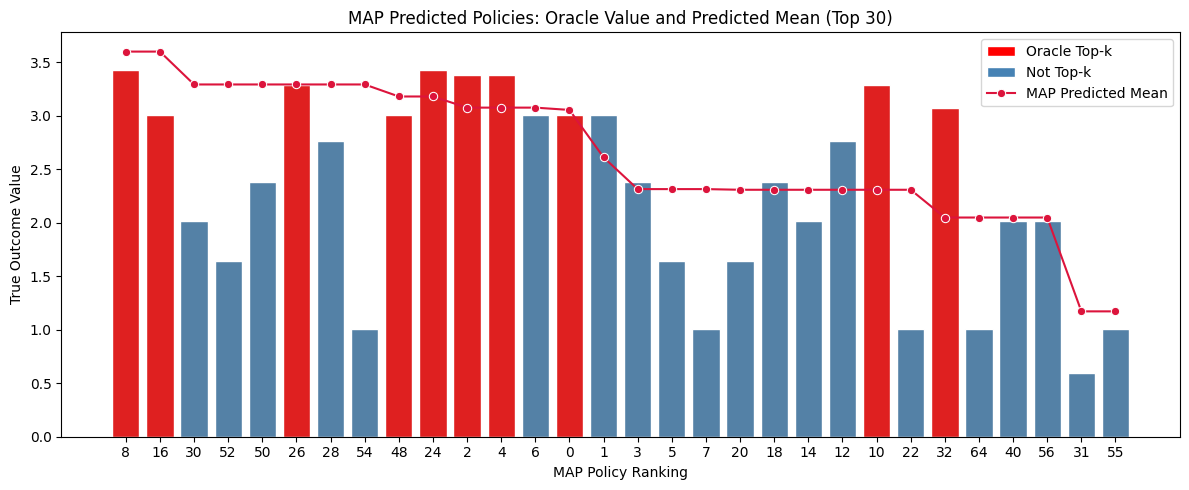

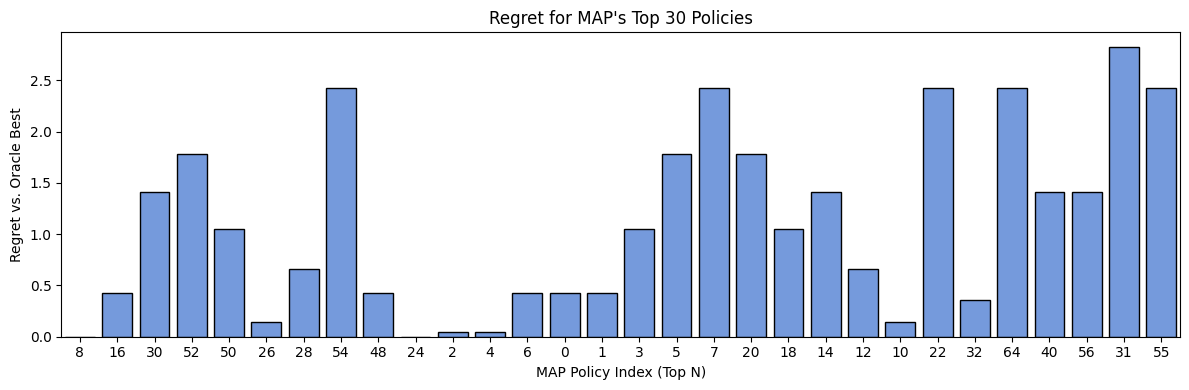

MAP top-30 min regret: 0.000  max regret: 2.828
Regression results: R2 = 0.326, Slope = 0.42, Intercept = 1.68


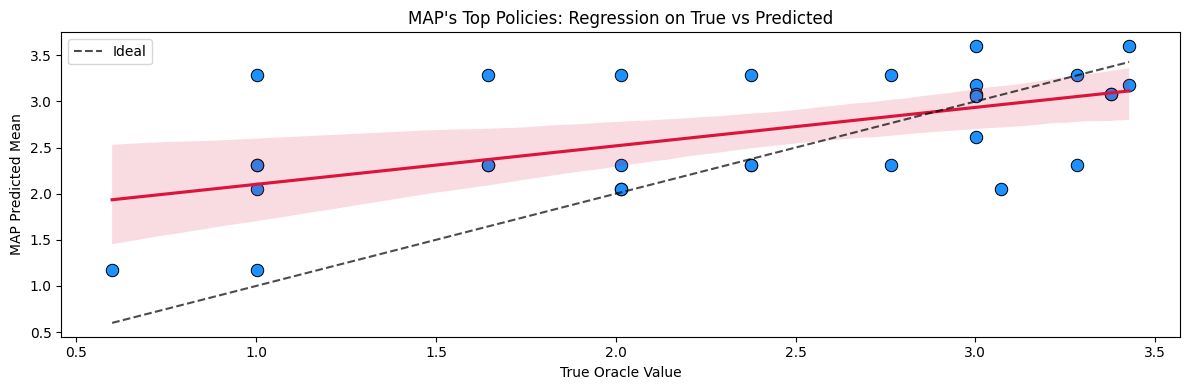

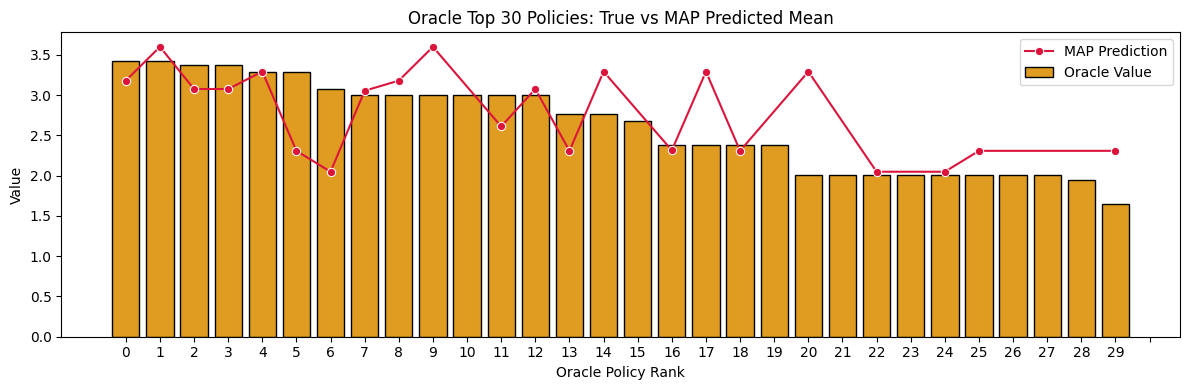

Oracle top-30 min/max regret (MAP predicted minus true): -1.279 / 1.023


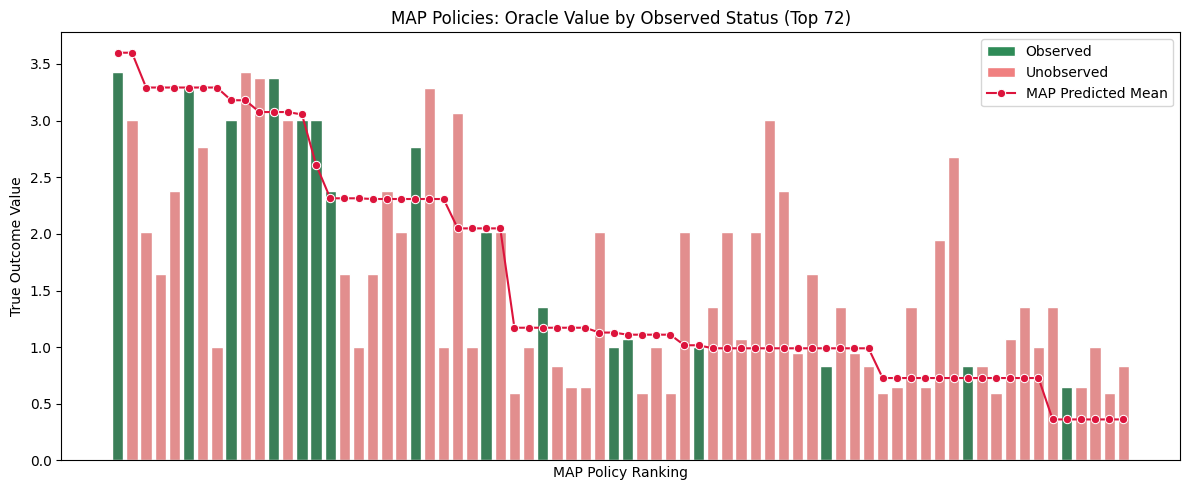

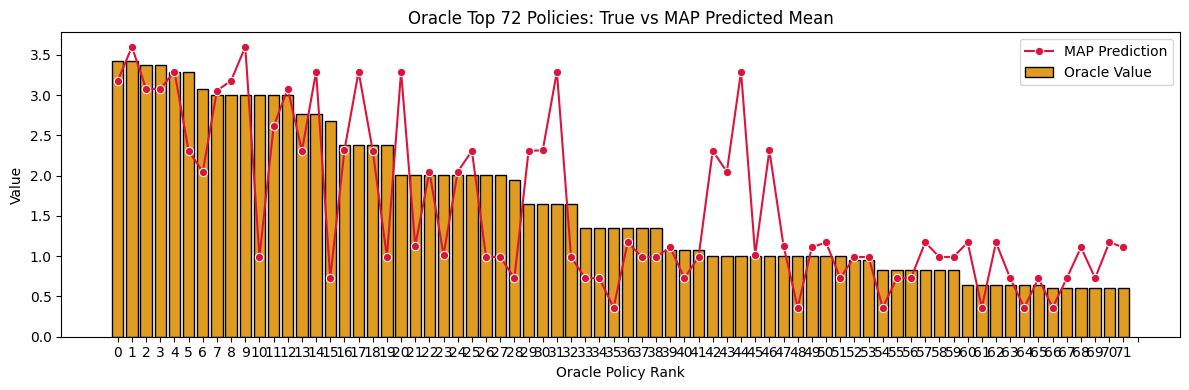

Oracle top-72 min/max regret (MAP predicted minus true): -2.290 / 2.013


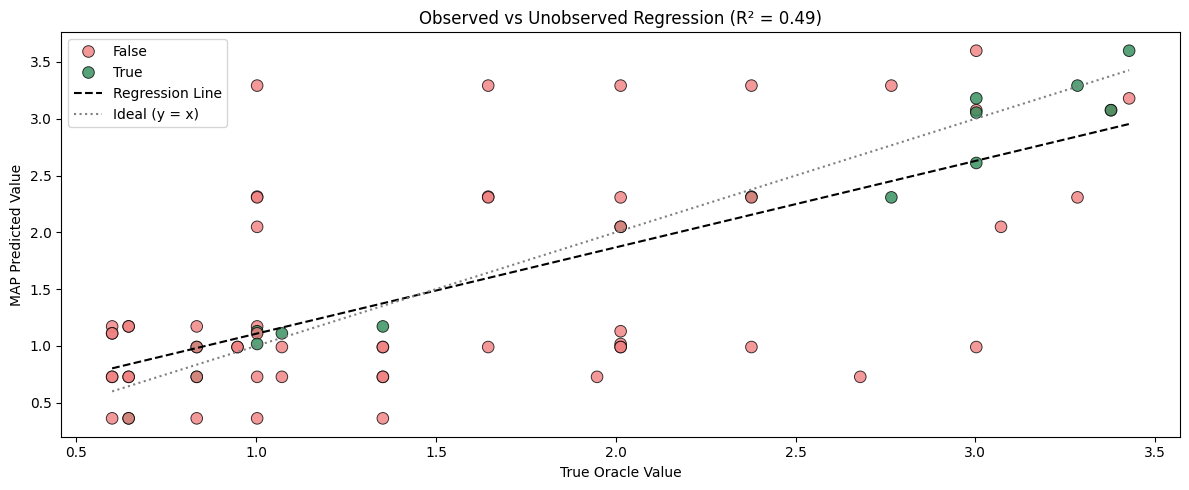

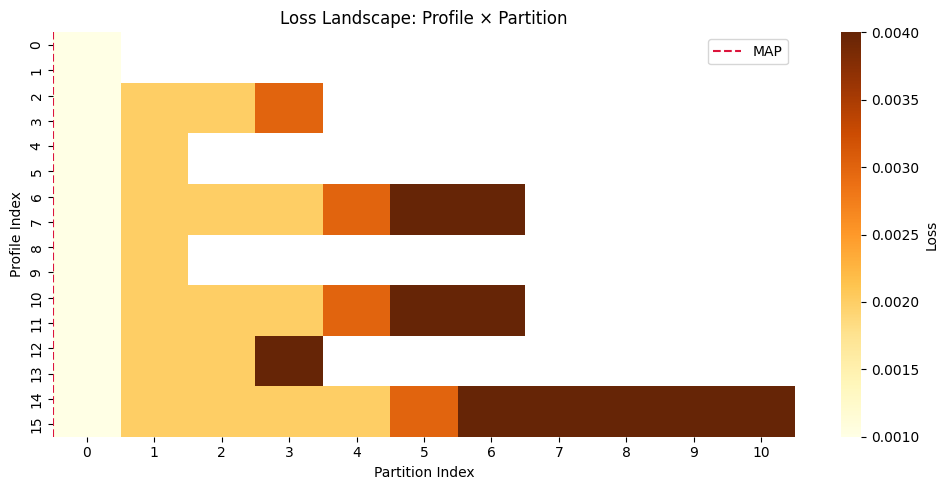

Number of partitions per profile: [1, 1, 4, 4, 2, 2, 7, 7, 2, 2, 7, 7, 4, 4, 11, 11]
Trying theta: 0.0192
Theta: 0.0192 -- RPS size: 0
Trying theta: 0.0242
Theta: 0.0242 -- RPS size: 0
Trying theta: 0.0292
Theta: 0.0292 -- RPS size: 0
Trying theta: 0.0342
Theta: 0.0342 -- RPS size: 0
Trying theta: 0.0392
Theta: 0.0392 -- RPS size: 0
Trying theta: 0.0442
Theta: 0.0442 -- RPS size: 0
Trying theta: 0.0492
Theta: 0.0492 -- RPS size: 18
Trying theta: 0.0482
Theta: 0.0482 -- RPS size: 1
Trying theta: 0.0492
Theta: 0.0492 -- RPS size: 18
Trying theta: 0.0502
Theta: 0.0502 -- RPS size: 141
Trying theta: 0.0512
Theta: 0.0512 -- RPS size: 666
Trying theta: 0.0522
Theta: 0.0522 -- RPS size: 2233
Return for next sweep
Trying theta: 0.0512
Theta: 0.0512 -- RPS size: 666
Trying theta: 0.0514
Theta: 0.0514 -- RPS size: 882
Trying theta: 0.0516
Theta: 0.0516 -- RPS size: 1070
End theta: 0.0516, RPS size: 1070
First-wave Rashomon set: 1070 feasible global partitions (combinations of per-profile pooling

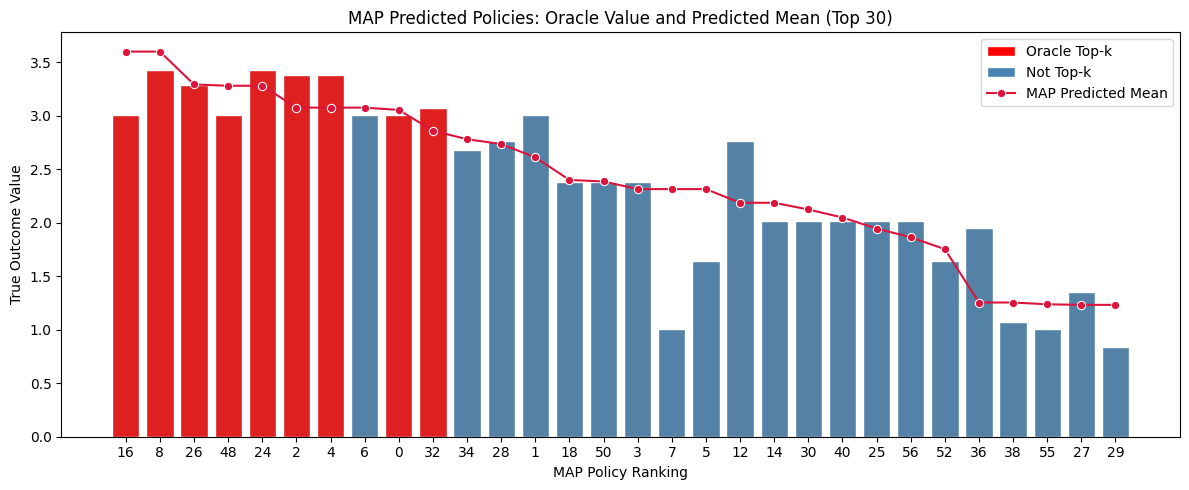

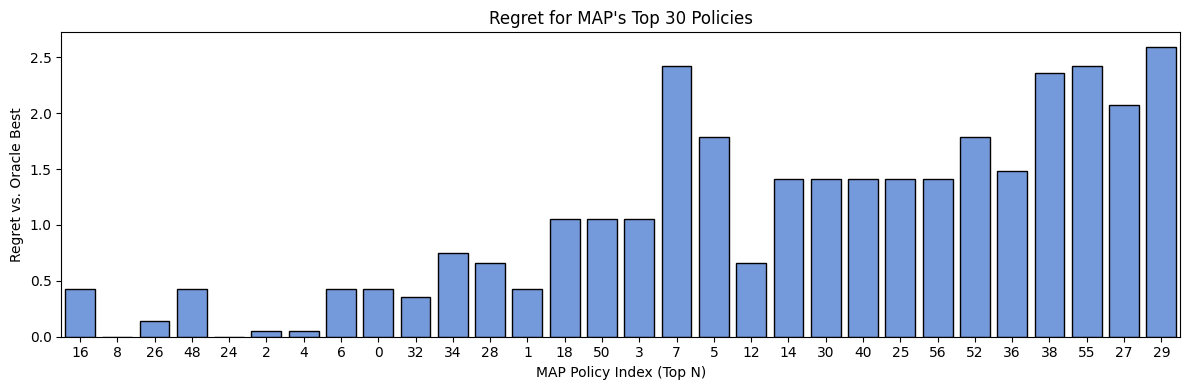

MAP top-30 min regret: 0.000  max regret: 2.593
Regression results: R2 = 0.779, Slope = 0.80, Intercept = 0.52


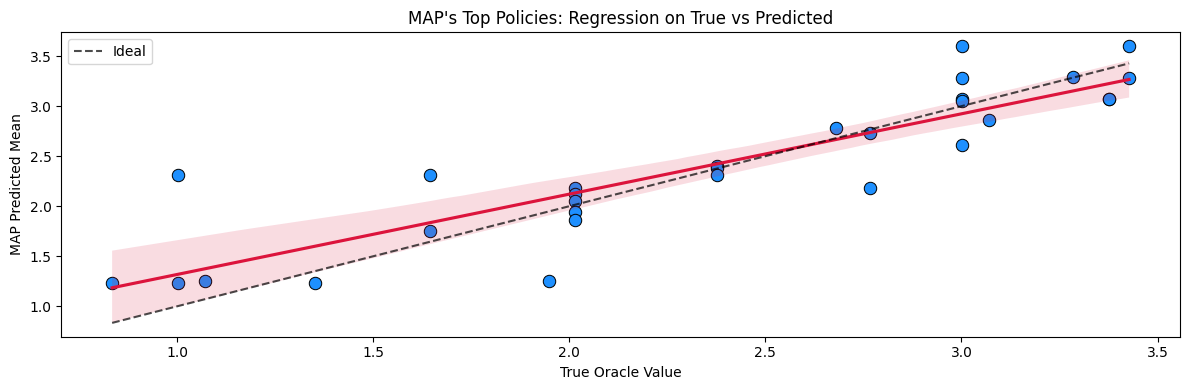

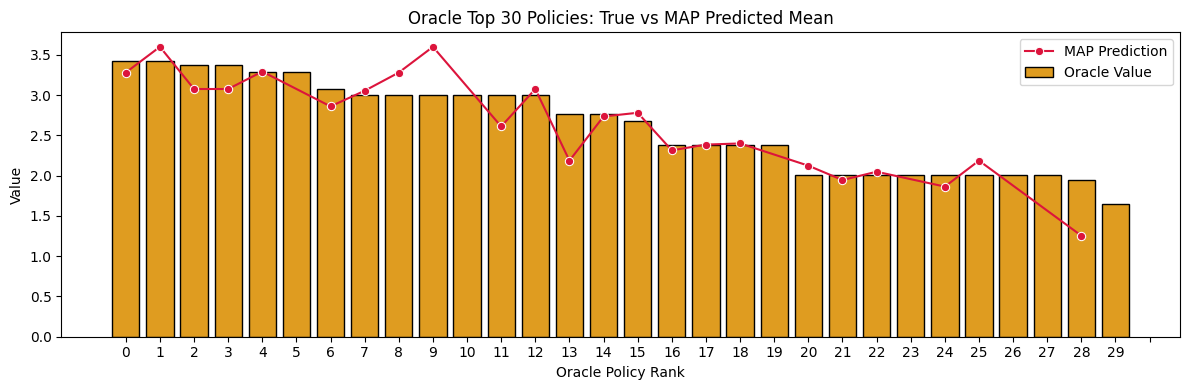

Oracle top-30 min/max regret (MAP predicted minus true): -0.597 / 0.694


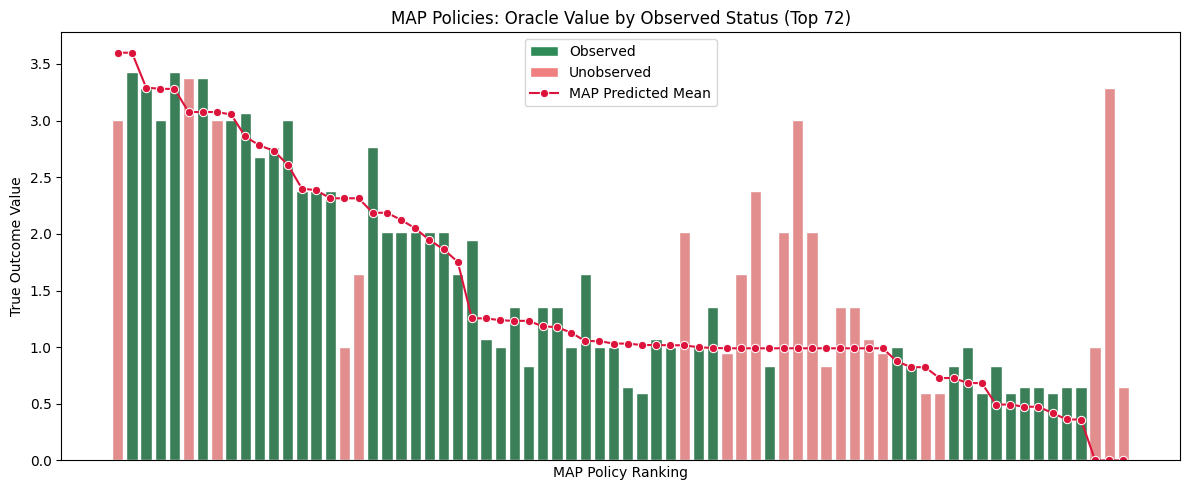

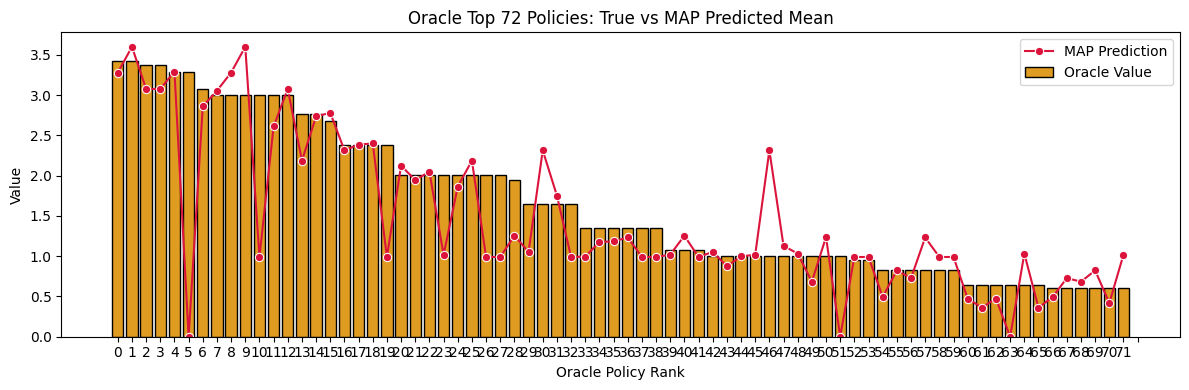

Oracle top-72 min/max regret (MAP predicted minus true): -1.312 / 3.284


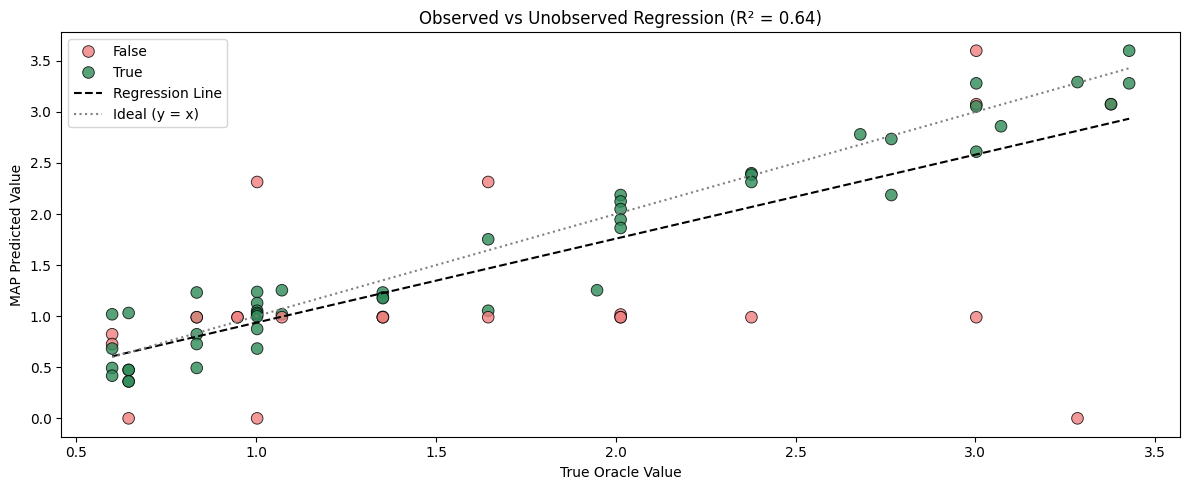

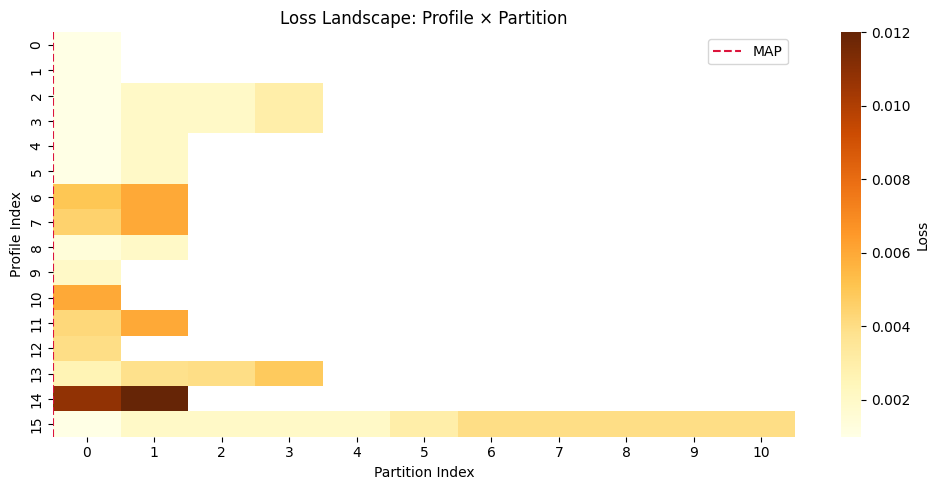

Number of partitions per profile: [1, 1, 4, 4, 2, 2, 2, 2, 2, 1, 1, 2, 1, 4, 2, 11]
Trying theta: 0.0516
Theta: 0.0516 -- RPS size: 0
Trying theta: 0.0566
Theta: 0.0566 -- RPS size: 0
Trying theta: 0.0616
Theta: 0.0616 -- RPS size: 0
Trying theta: 0.0666
Theta: 0.0666 -- RPS size: 0
Trying theta: 0.0716
Theta: 0.0716 -- RPS size: 1490
Return for next sweep
Trying theta: 0.0666
Theta: 0.0666 -- RPS size: 0
Trying theta: 0.0676
Theta: 0.0676 -- RPS size: 16
Trying theta: 0.0686
Theta: 0.0686 -- RPS size: 87
Trying theta: 0.0696
Theta: 0.0696 -- RPS size: 268
Trying theta: 0.0706
Theta: 0.0706 -- RPS size: 701
Trying theta: 0.0716
Theta: 0.0716 -- RPS size: 1490
Return for next sweep
Trying theta: 0.0706
Theta: 0.0706 -- RPS size: 701
Trying theta: 0.0708
Theta: 0.0708 -- RPS size: 837
Trying theta: 0.0710
Theta: 0.0710 -- RPS size: 973
Trying theta: 0.0712
Theta: 0.0712 -- RPS size: 1113
End theta: 0.0712, RPS size: 1113
First-wave Rashomon set: 1113 feasible global partitions (combinati

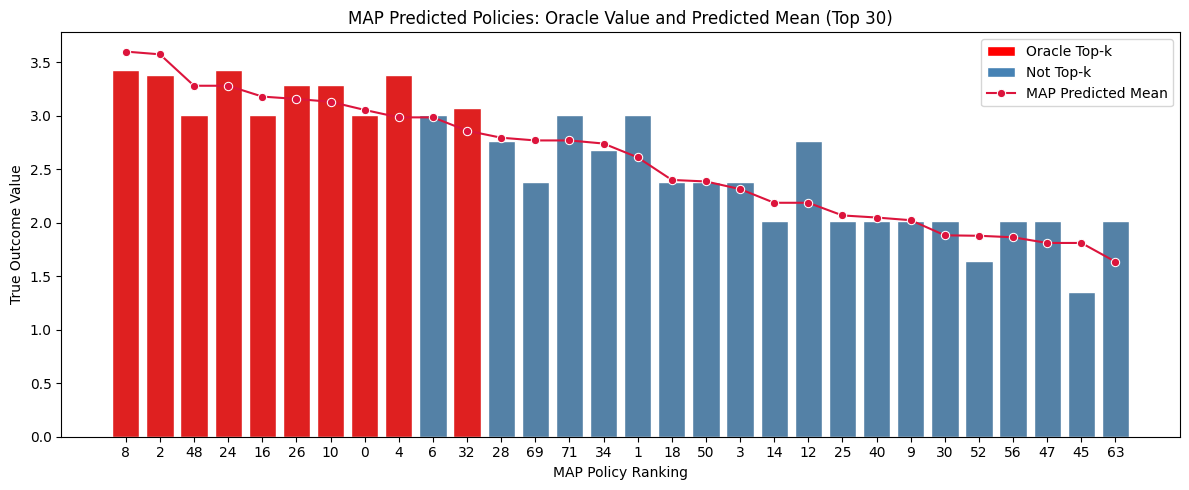

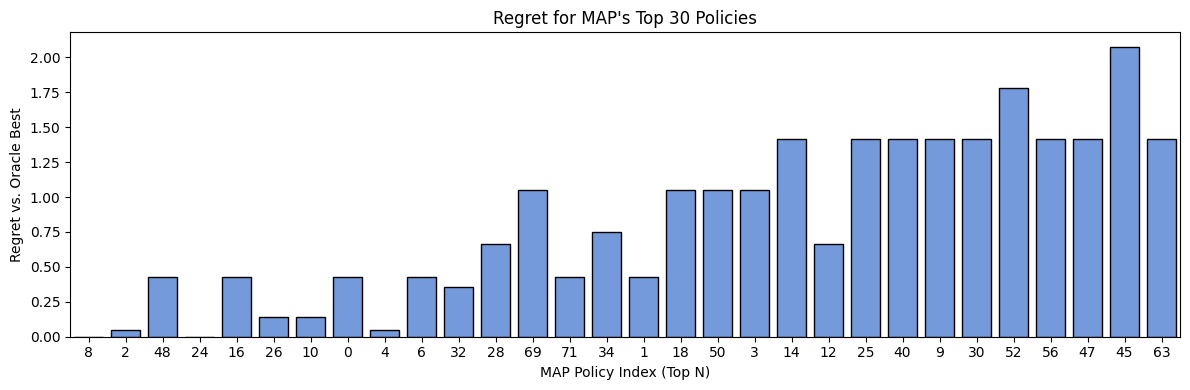

MAP top-30 min regret: 0.000  max regret: 2.076
Regression results: R2 = 0.842, Slope = 0.89, Intercept = 0.25


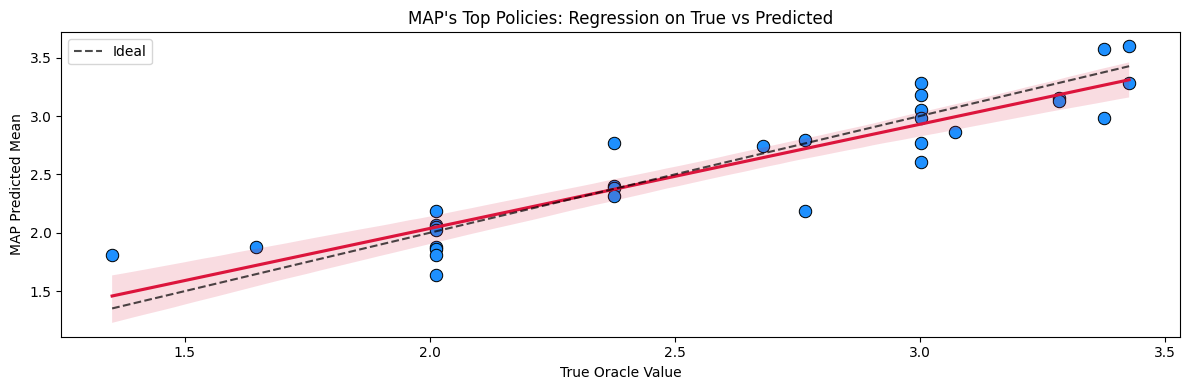

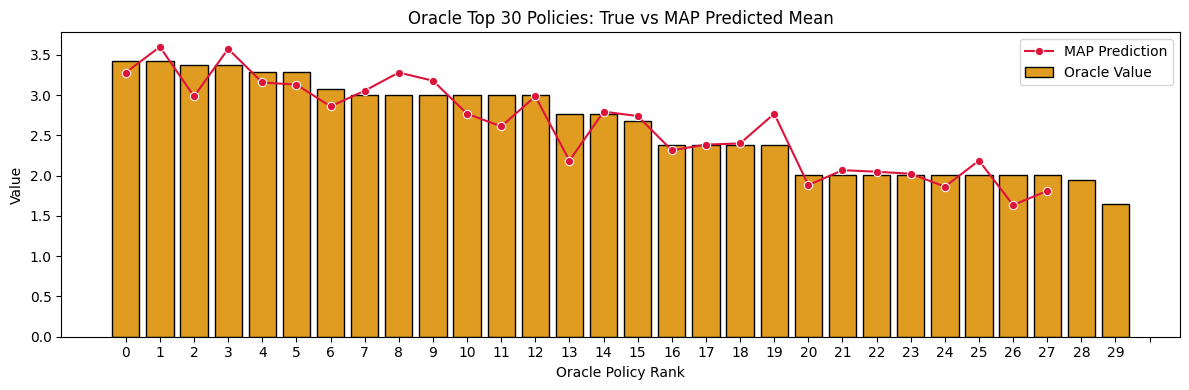

Oracle top-30 min/max regret (MAP predicted minus true): -0.392 / 0.580


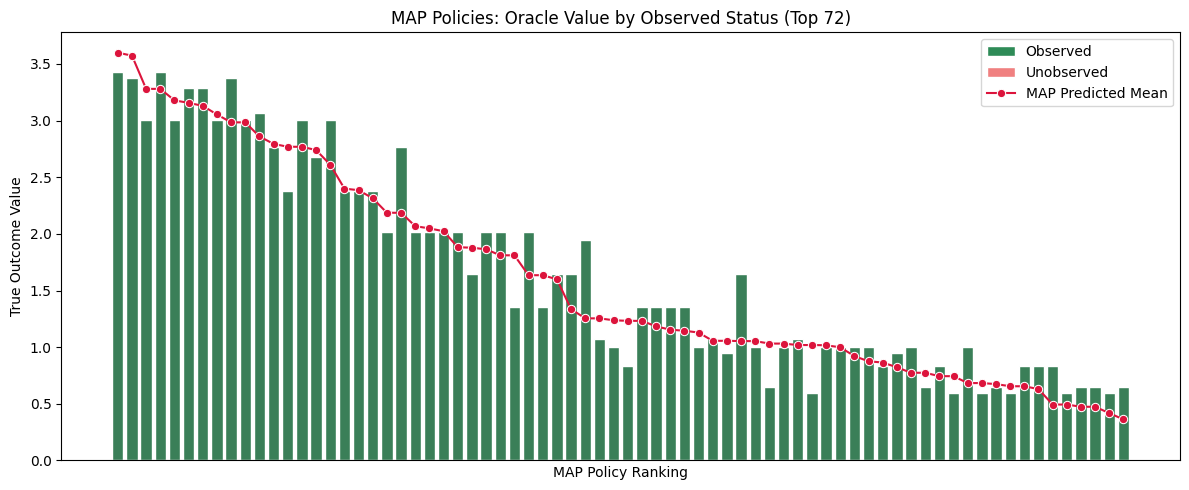

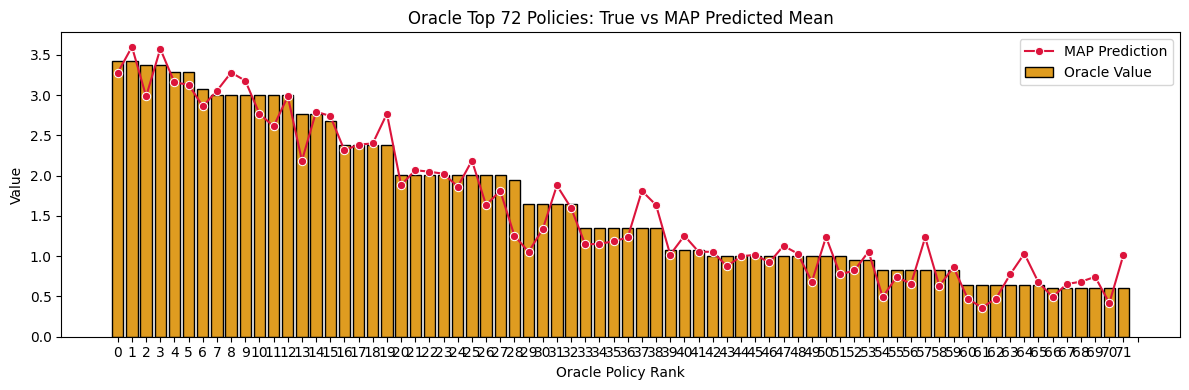

Oracle top-72 min/max regret (MAP predicted minus true): -0.459 / 0.694


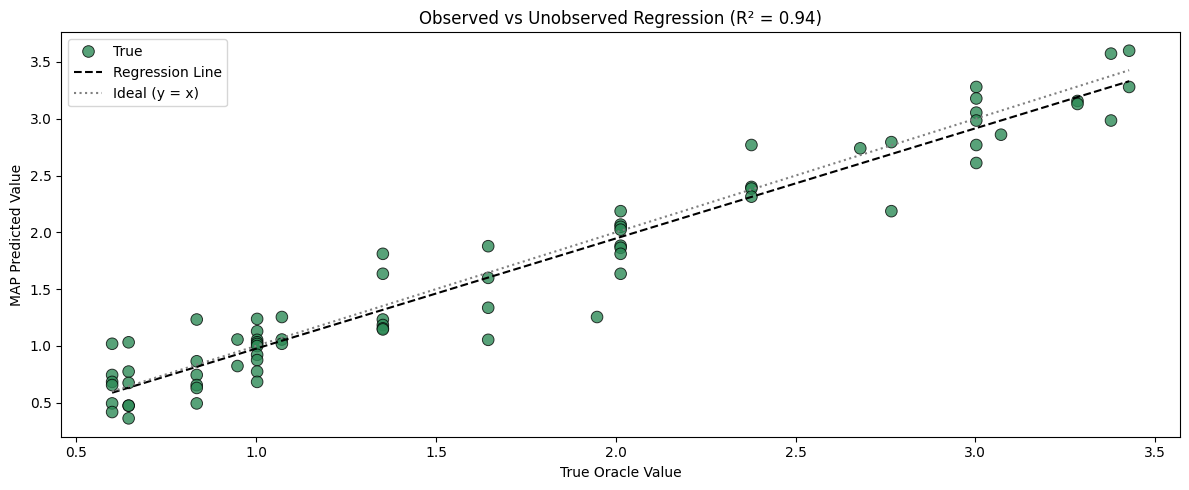

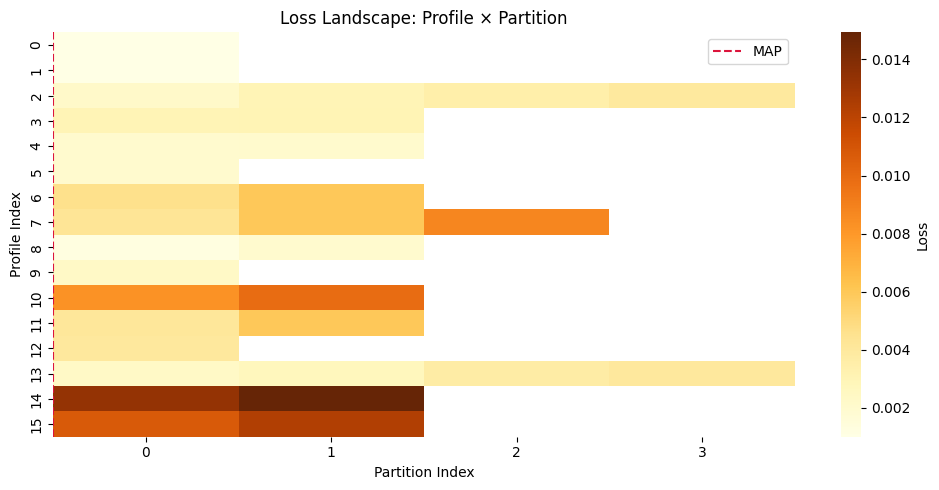

Number of partitions per profile: [1, 1, 4, 2, 2, 1, 2, 3, 2, 1, 2, 2, 1, 4, 2, 2]
Trying theta: 0.0712
Theta: 0.0712 -- RPS size: 0
Trying theta: 0.0762
Theta: 0.0762 -- RPS size: 92
Trying theta: 0.0752
Theta: 0.0752 -- RPS size: 26
Trying theta: 0.0762
Theta: 0.0762 -- RPS size: 92
Trying theta: 0.0772
Theta: 0.0772 -- RPS size: 255
Trying theta: 0.0782
Theta: 0.0782 -- RPS size: 582
Trying theta: 0.0792
Theta: 0.0792 -- RPS size: 1210
Return for next sweep
Trying theta: 0.0782
Theta: 0.0782 -- RPS size: 582
Trying theta: 0.0784
Theta: 0.0784 -- RPS size: 678
Trying theta: 0.0786
Theta: 0.0786 -- RPS size: 780
Trying theta: 0.0788
Theta: 0.0788 -- RPS size: 925
Trying theta: 0.0790
Theta: 0.0790 -- RPS size: 1070
End theta: 0.0790, RPS size: 1070
First-wave Rashomon set: 1070 feasible global partitions (combinations of per-profile poolings).


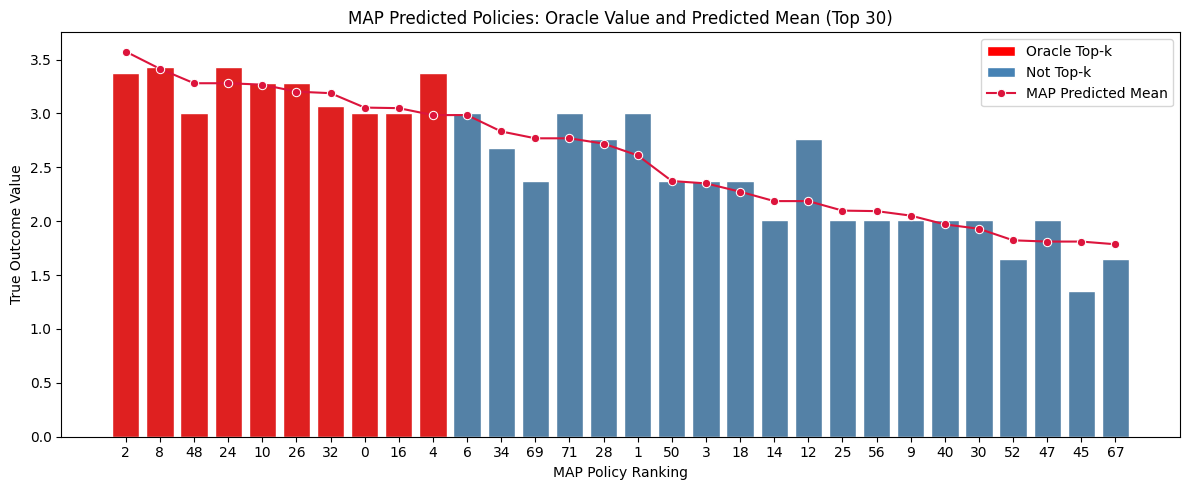

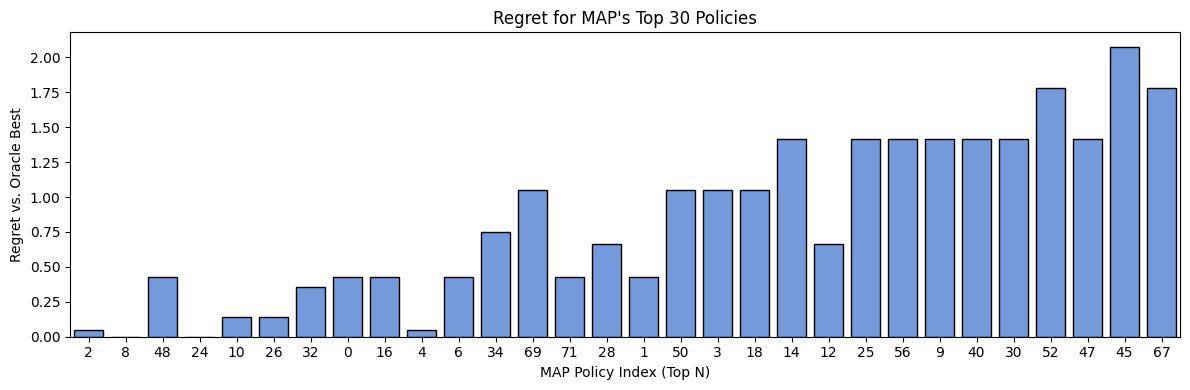

MAP top-30 min regret: 0.000  max regret: 2.076
Regression results: R2 = 0.869, Slope = 0.86, Intercept = 0.35


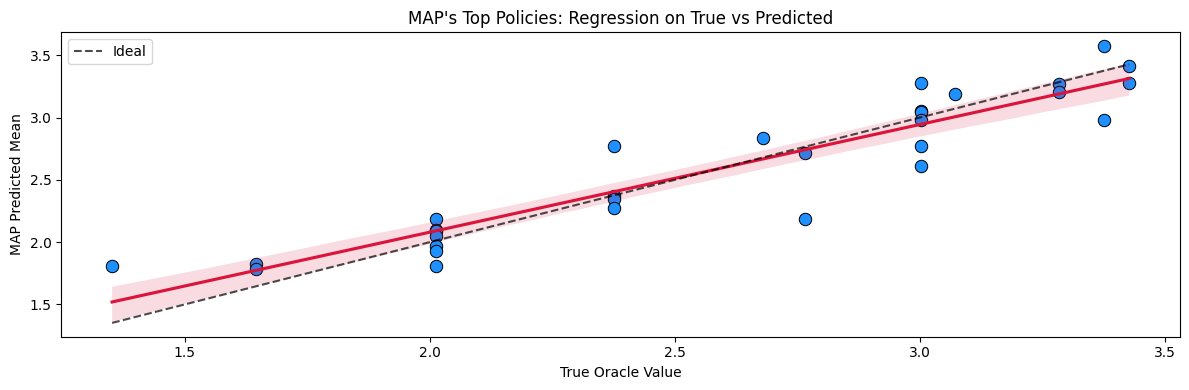

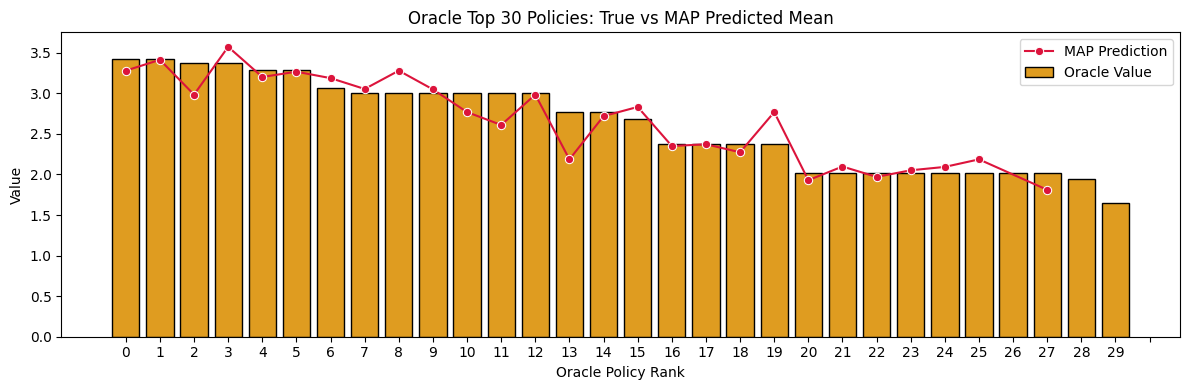

Oracle top-30 min/max regret (MAP predicted minus true): -0.392 / 0.580


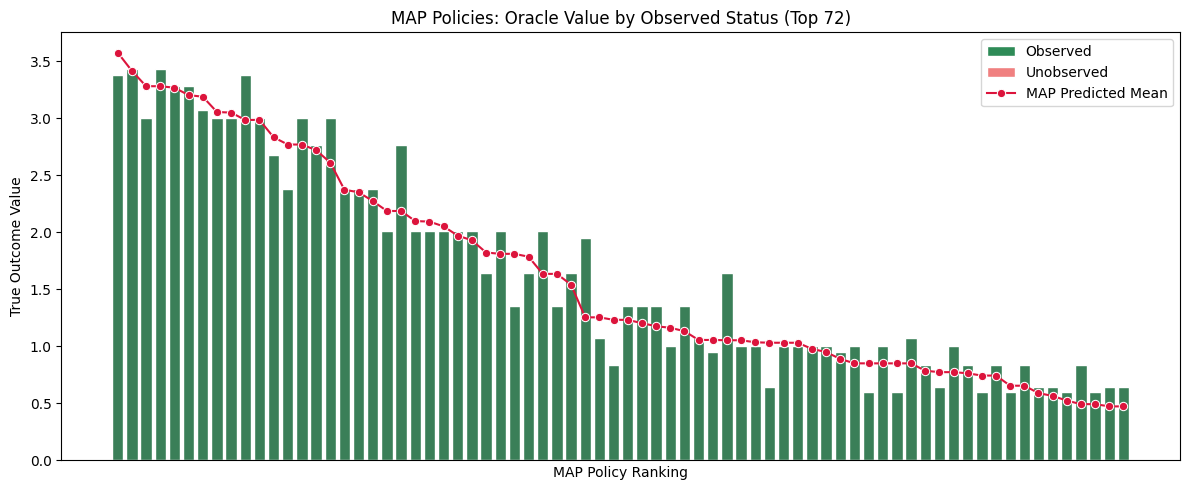

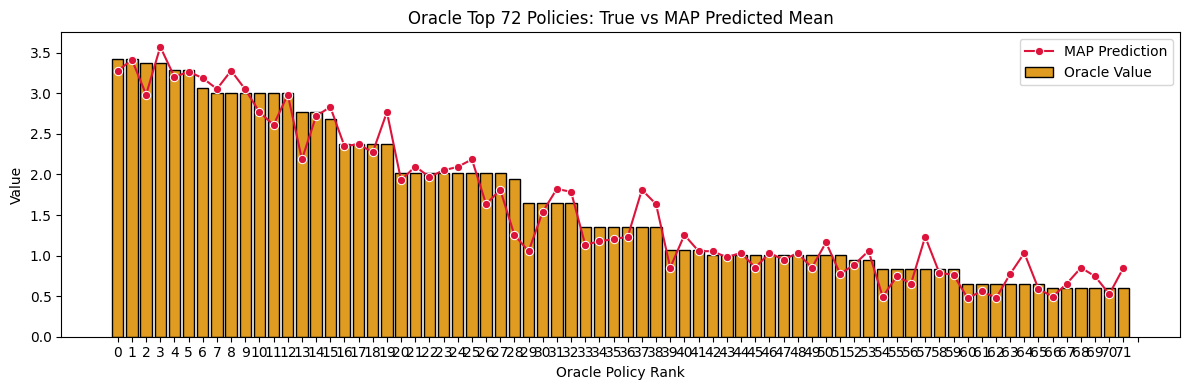

Oracle top-72 min/max regret (MAP predicted minus true): -0.459 / 0.694


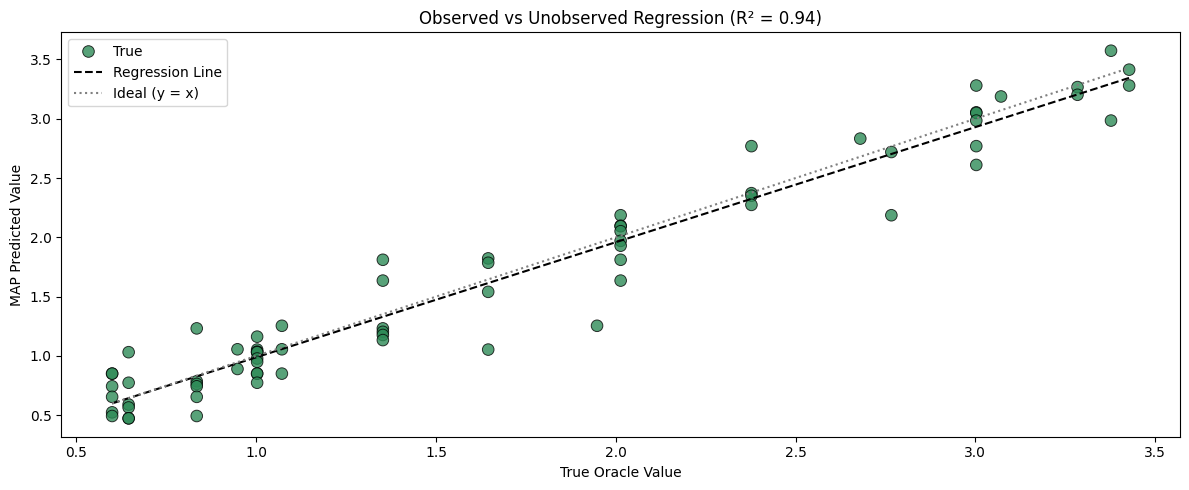

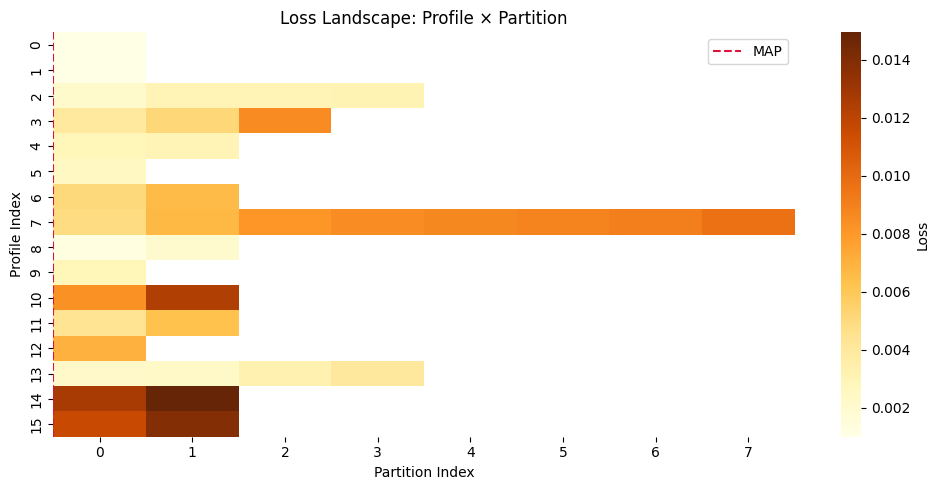

Number of partitions per profile: [1, 1, 4, 3, 2, 1, 2, 8, 2, 1, 2, 2, 1, 4, 2, 2]
Trying theta: 0.0790
Theta: 0.0790 -- RPS size: 131
Trying theta: 0.0780
Theta: 0.0780 -- RPS size: 45
Trying theta: 0.0790
Theta: 0.0790 -- RPS size: 131
Trying theta: 0.0800
Theta: 0.0800 -- RPS size: 315
Trying theta: 0.0810
Theta: 0.0810 -- RPS size: 646
Trying theta: 0.0820
Theta: 0.0820 -- RPS size: 1191
Return for next sweep
Trying theta: 0.0810
Theta: 0.0810 -- RPS size: 646
Trying theta: 0.0812
Theta: 0.0812 -- RPS size: 750
Trying theta: 0.0814
Theta: 0.0814 -- RPS size: 846
Trying theta: 0.0816
Theta: 0.0816 -- RPS size: 932
Trying theta: 0.0818
Theta: 0.0818 -- RPS size: 1046
End theta: 0.0818, RPS size: 1046
First-wave Rashomon set: 1046 feasible global partitions (combinations of per-profile poolings).


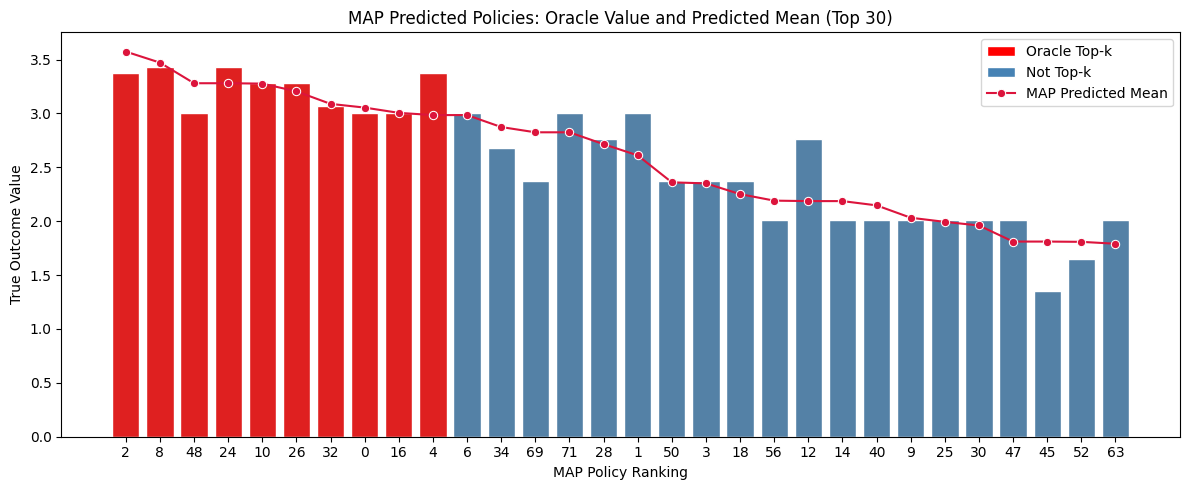

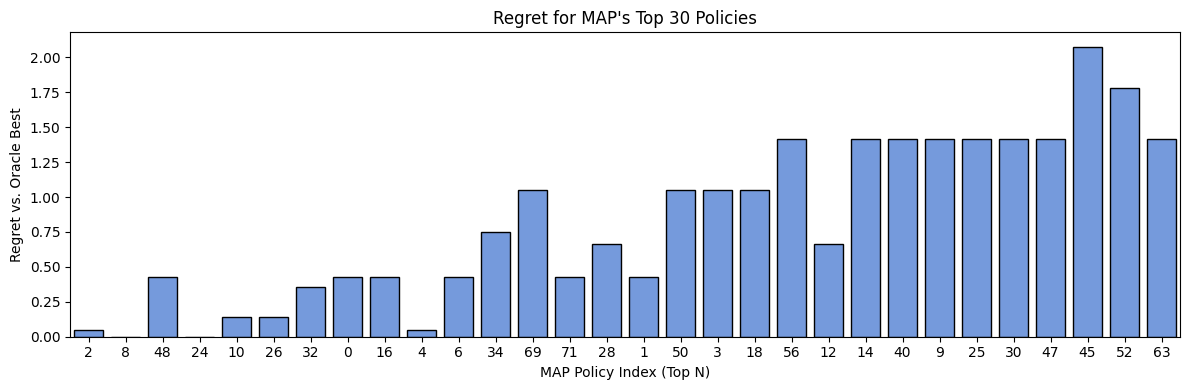

MAP top-30 min regret: 0.000  max regret: 2.076
Regression results: R2 = 0.854, Slope = 0.87, Intercept = 0.32


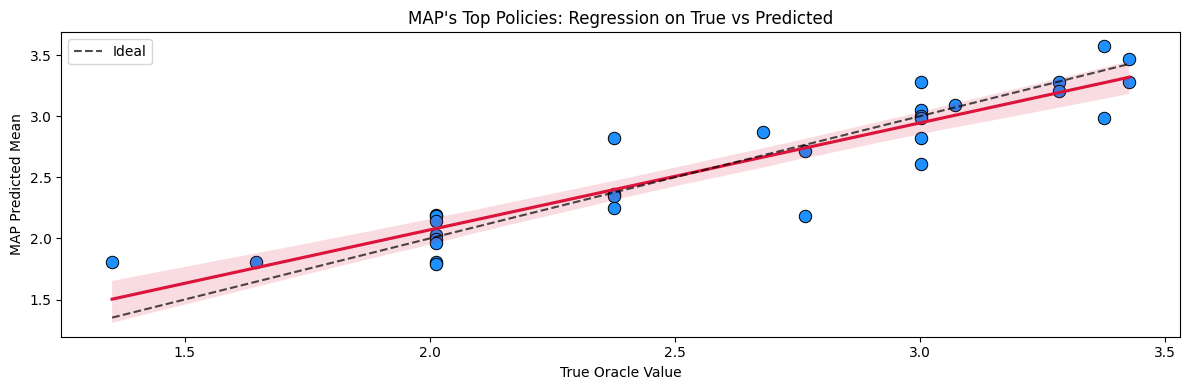

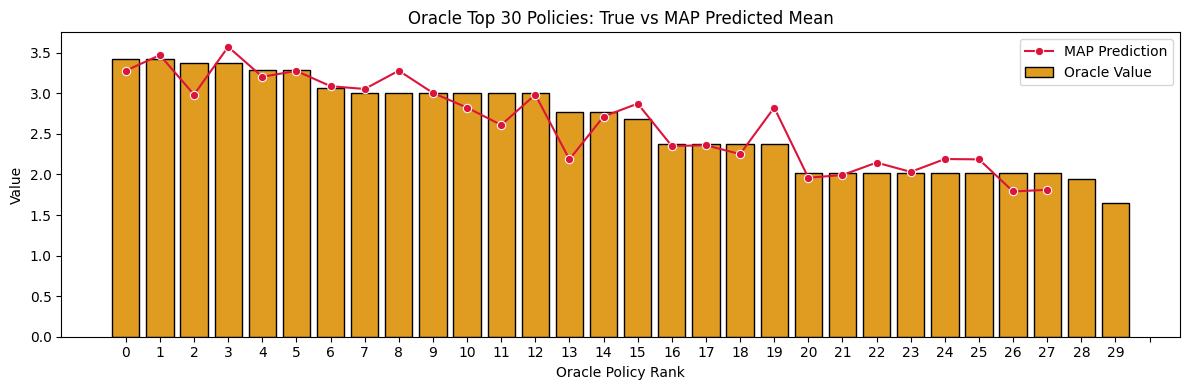

Oracle top-30 min/max regret (MAP predicted minus true): -0.448 / 0.580


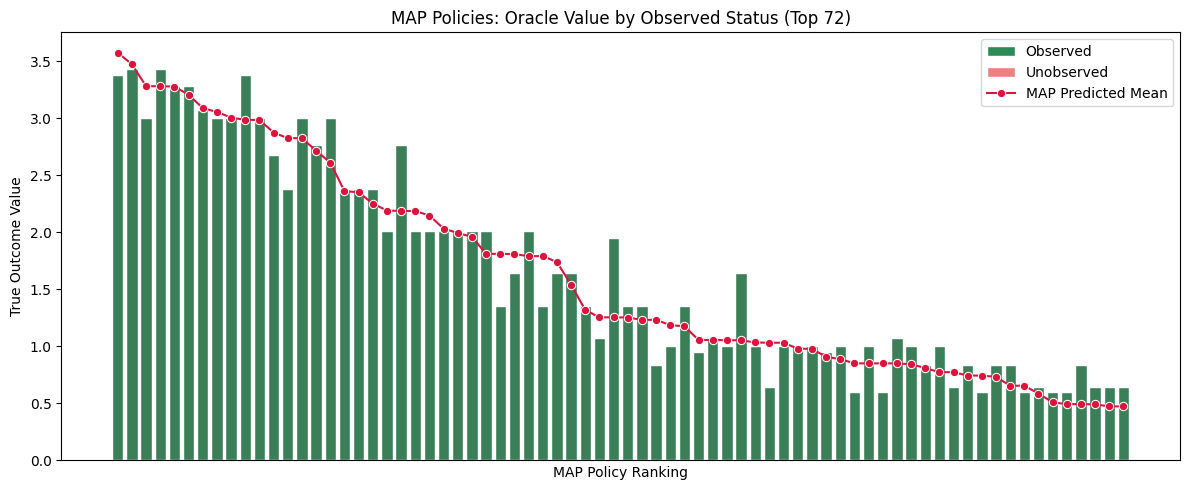

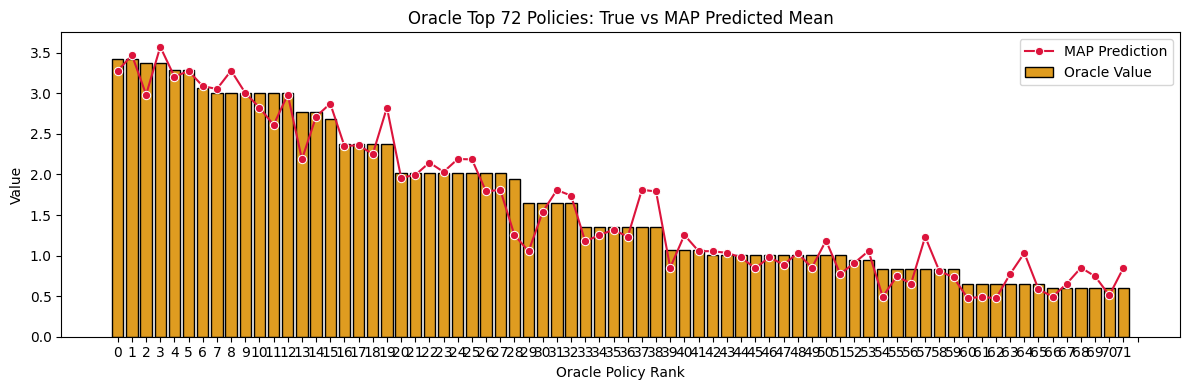

Oracle top-72 min/max regret (MAP predicted minus true): -0.459 / 0.694


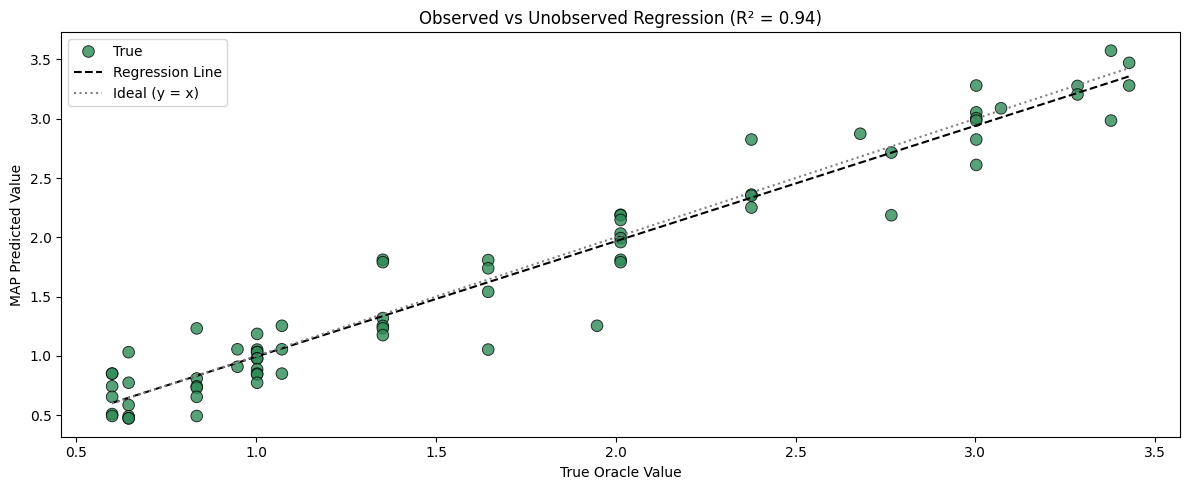

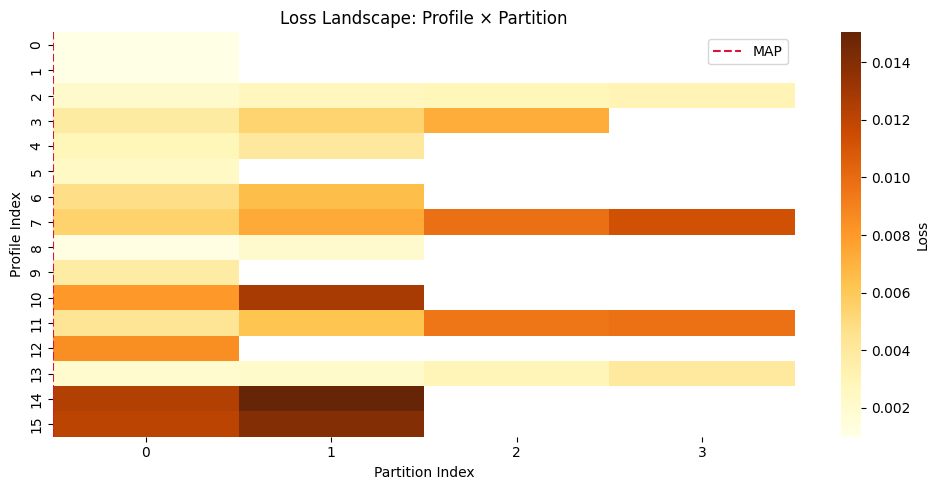

Number of partitions per profile: [1, 1, 4, 3, 2, 1, 2, 4, 2, 1, 2, 4, 1, 4, 2, 2]


In [6]:
metrics_per_wave = []
scores = []

D = np.empty((0, 1), dtype=int)
y = np.empty((0, 1), dtype=float)

for wave_number in range(1, feasible_waves + 1):
    np.random.seed(wave_number)
    if wave_number == 1:
        D_wave = get_initial_coverage_allocations(policies_ids_profiles)
        D_wave = np.array(D_wave, dtype=int).reshape(-1, 1)
    else:
        n_wave = n[wave_number - 1]
        top_indices = np.argpartition(scores, -n_wave)[-n_wave:]
        D_wave = np.array(top_indices, dtype=int).reshape(-1, 1)

    X_wave, y_wave = generate_data_from_assignments(D_wave, all_policies, oracle_outcomes, sig=sig)

    # Accumulate full data so far
    D = np.vstack([D, D_wave])
    y = np.vstack([y, y_wave])

    policy_stats = compute_policy_means(D, y, num_policies)

    observed_policy_indices = np.where(policy_stats[:, 1] > 0)[0]
    unobserved_policy_indices = np.where(policy_stats[:, 1] == 0)[0]
    observed_profiles = {
    k for k, ids in policies_ids_profiles.items()
    if np.any(policy_stats[ids, 1] > 0)
    }
    unobserved_profiles = set(policies_ids_profiles.keys()) - observed_profiles

    observed_policies_per_profile = {
    k: list(set(ids) & set(observed_policy_indices))
    for k, ids in policies_ids_profiles.items()
    }

    if wave_number == 1:
        theta = theta_init
        theta_step = theta_init_step

    max_steps = 50
    steps = 0
    num_sweeps = 3
    for sweep in range(num_sweeps):
        steps = 0
        while steps < max_steps:
            if verbose:
                print(f"Trying theta: {theta:.4f}")
            R_set, R_profiles = RAggregate(
                M, R, H, D, y, theta,
                reg=lambda_reg, num_workers=num_workers, verbose=False
            )
            if verbose:
                print(f"Theta: {theta:.4f} -- RPS size: {len(R_set)}")
            if len(R_set) >= max_rset_size and sweep < num_sweeps - 1:
                print(f"Return for next sweep")
                theta -= theta_step
                theta_step = theta_step / 5
                break
            if len(R_set) >= max_rset_size and sweep == num_sweeps - 1:
                # keep same theta for next wave, but bring the step up in size
                theta_step = theta_step * (5**(num_sweeps-1))
                break
            if len(R_set) > 0 and sweep == 0:
                theta_step /= 5
                theta-=theta_step
                break
            theta += theta_step
            steps += 1

    if len(R_set) == 0:
        print("Warning: No feasible Rashomon set found within range.")
    elif verbose:
        print(f"End theta: {theta:.4f}, RPS size: {len(R_set)}")
        print(f"First-wave Rashomon set: {len(R_set)} feasible global partitions (combinations of per-profile poolings).")

    # Initialization
    num_partitions = len(R_set)

    regrets = []
    best_pred_indices_all = []
    policy_indices_all = []
    policy_means_all = []

    sorted_idx_all = []
    sorted_means_all = []

    partition_losses = np.zeros(num_partitions)

    posterior_mse = []
    posterior_best_mse = []
    posterior_iou = []

    pi_policies_r_list = []
    pool_means_r_list = []

    # track pools for each profile k, for each rashomon set r
    for r, partition_r in enumerate(R_set):
        pi_policies_profiles_r = {}

        for k, profile in enumerate(profiles):
            sigma_k = R_profiles[k].sigma[partition_r[k]]
            if sigma_k is None:
                # the entire profile is just one pool, so we map all policies to single pool 0.
                n_policies_profile = len(policies_profiles_masked[k])
                pi_policies_r_k = {i: 0 for i in range(n_policies_profile)}
            else:
                _, pi_policies_r_k = extract_pools(policies_profiles_masked[k], sigma_k)

            # each profile (0-indexed) holds a dictionary of each of the included policies (locally 0-indexed, can be remapped with helpers), and indicates assignment to local pool number
            pi_policies_profiles_r[k] = pi_policies_r_k

        # aggregate into global partition structures
        pi_pools_r, pi_policies_r = aggregate_pools(pi_policies_profiles_r, policies_ids_profiles)
        pool_means_r = compute_pool_means(policy_stats, pi_pools_r)

        pi_policies_r_list.append(pi_policies_r)
        pool_means_r_list.append(pool_means_r)

        # Partition loss
        partition_losses[r] = sum(R_profiles[k].loss[partition_r[k]] for k in range(len(partition_r)))

        # Predictions by policy
        policy_indices = np.array(list(pi_policies_r.keys()))
        policy_means = np.array([pool_means_r[pi_policies_r[idx]] for idx in policy_indices])
        order = np.argsort(-policy_means)
        sorted_idx = policy_indices[order]
        sorted_means = policy_means[order]

        # Store results
        policy_indices_all.append(policy_indices)
        policy_means_all.append(policy_means)
        sorted_idx_all.append(sorted_idx)
        sorted_means_all.append(sorted_means)

        best_pred = sorted_idx[0]
        regret = float(oracle_outcomes[top_k_indices[0]] - oracle_outcomes[best_pred])
        regrets.append(regret)
        best_pred_indices_all.append(best_pred)

        # Posterior-weighted metrics
        y_r_est = make_predictions(D, pi_policies_r, pool_means_r)

        mse = np.mean((y_r_est - y) ** 2) # mse on outcomes
        best_mse = (oracle_outcomes[top_k_indices[0]] - oracle_outcomes[best_pred]) ** 2
        iou = len(set(sorted_idx[:top_k]) & set(top_k_indices)) / len(set(sorted_idx[:top_k]) | set(top_k_indices))

        posterior_mse.append(mse)
        posterior_best_mse.append(best_mse)
        posterior_iou.append(iou)

    # Posterior weights and expected metrics
    posterior_weights = np.exp(-partition_losses)
    posterior_weights /= posterior_weights.sum() if posterior_weights.sum() > 0 else 1.0
    map_idx = np.argmin(partition_losses)
    map_loss = partition_losses[map_idx]

    policy_indices = policy_indices_all[map_idx]
    policy_means = policy_means_all[map_idx]
    order = np.argsort(-policy_means)

    pi_policies_r = pi_policies_r_list[map_idx]

    sorted_idx = sorted_idx_all[map_idx]
    sorted_means = sorted_means_all[map_idx]
    oracle_values = oracle_outcomes[sorted_idx]
    oracle_ranks = oracle_policy_to_rank[sorted_idx]
    is_topk = [i in top_k_indices for i in sorted_idx]

    expected_mse = np.dot(posterior_weights, posterior_mse)
    expected_best_mse = np.dot(posterior_weights, posterior_best_mse)
    expected_iou = np.dot(posterior_weights, posterior_iou)
    expected_regret = np.dot(posterior_weights, regrets)

    metrics_per_wave.append({
        "wave": wave_number,
        "theta": theta,
        "rps_size": len(R_set),
        "expected_regret": expected_regret,
        "expected_mse": expected_mse,
        "expected_best_mse": expected_best_mse,
        "expected_iou": expected_iou,
        "map_loss": map_loss
    })

    scores, cov_norm, var_norm, ent_norm = compute_adaptive_proxy_scores(policy_stats, map_idx, pi_policies_r_list, posterior_weights)

    if verbose:
        # MAP Summary and regret plots --
        df_map = visualizations.plot_map_true_vs_predicted_bar_topk(
            sorted_idx=sorted_idx,
            sorted_means=sorted_means,
            oracle_beta=oracle_outcomes,
            oracle_ranks=oracle_policy_to_rank,
            top_k_indices=top_k_indices,
            N=n_preview
        )
        visualizations.plot_map_regret_bar(sorted_idx, oracle_outcomes, top_k_indices[0], N=n_preview)
        visualizations.plot_map_regression(df_map)
        visualizations.plot_oracle_ordered_bar(df_map, top_k_indices, oracle_outcomes, all_policies, N=n_preview)

        df_map_obs = visualizations.plot_map_true_vs_predicted_bar_observed(sorted_idx, sorted_means, oracle_outcomes, oracle_ranks, observed_policy_indices, N=num_policies)
        visualizations.plot_oracle_ordered_bar(df_map_obs, top_k_indices, oracle_outcomes, all_policies, N=num_policies)
        visualizations.plot_map_regression_observed(df_map_obs)

        profile_losses = [rp.loss for rp in R_profiles]
        visualizations.plot_minimax_risk_matrix(profile_losses, map_idx=map_idx)
        print(f"Number of partitions per profile: {[len(p) for p in profile_losses]}")